# Lab 1: image rectification

This lab has two main goals:

1) Get more familiar with the hierarchy of 2D transformation <br>

2) Remove the projective distortion of an image of a planar object (image rectification)

The following file combines some text cells (Markdown cells) and code cells. Some parts of the code need to be completed. All tasks you need to complete are marked in <span style='color:Green'> green.  </span>

In [471]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from scipy.ndimage import map_coordinates
from numpy import linalg as LA
from utils import line_draw, plot_img, crop, show_images, get_line_endpoints
from typing import Tuple, List

In [472]:
yellow = (255, 255, 0)
green = (0, 255, 0)
cyan = (0, 255, 255)
blue = (0, 0, 255)
carmesi = (128, 32, 64)
red = (255, 0, 0)

## **1. Applying image transformations**

In this first part of the lab you will apply different types of 2D transformations to a given image. For that, you first need to create a function that applies a homography to animage.

<span style='color:Green'> - Create the function  *apply_H* that gets as input a homography and
an image and returns the image transformed by the homography. </span>

Note: The size of the transformed image has to be automatically set so as to 
contain the whole transformed image.
You will need to interpolate the image values at some points, for that,
you may use the function *scipy.ndimage.map_coordinates*

In [473]:
def forward_warping(p: np.ndarray, H: np.ndarray) -> np.ndarray:
    """
    Forward warp a point with a given Homography H.
    """
    x1, x2, x3 = H @ p.T
    return x1/x3, x2/x3


def backward_warping(p: np.ndarray, H: np.ndarray) -> np.ndarray:
    """
    Backward warp a point with a given Homography H.
    """
    x1, x2, x3 = LA.inv(H) @ np.array(p)
    return x1/x3, x2/x3
    

def find_max_size(m: int, n: int, H: np.ndarray) -> Tuple[int, int, int, int]:
    corners = np.array([[0, 0, 1], [n, 0, 1], [0, m, 1], [n, m, 1]])
    corners = np.array(forward_warping(corners, H))

    min_x = np.ceil(corners[0].min())
    max_x = np.floor(corners[0].max())
    min_y = np.ceil(corners[1].min())
    max_y = np.floor(corners[1].max())

    return max_x, min_x, max_y, min_y


def apply_H(I: np.ndarray, H: np.ndarray) -> Tuple[np.uint, tuple]:
    """
    Applies a homography to an image.

    Args:
        I (np.array): Image to be transformed.
        H (np.array): Homography matrix. The homography is defined as
            H = [[h11, h12, h13],
                [h21, h22, h23],
                [h31, h32, h33]]

    Returns:
        np.array: Transformed image.
    """
    m, n, C = I.shape
    max_x, min_x, max_y, min_y = find_max_size(m, n, H)

    # Compute size of output image
    width_canvas, height_canvas = max_x - min_x, max_y - min_y

    # Create grid in the output space
    X, Y = np.meshgrid(np.arange(min_x, max_x), np.arange(min_y, max_y))
    X_flat, Y_flat = X.flatten(), Y.flatten()

    # Generate matrix with output points in homogenous coordinates
    dest_points = np.array([X_flat, Y_flat, np.ones_like(X_flat)])

    # Backward warp output points to their source points
    source_x, source_y = backward_warping(dest_points, H)

    # Get src_x and src_y in meshgrid-like coordinates
    source_x = np.reshape(source_x, X.shape)
    source_y = np.reshape(source_y, Y.shape)

    # Set up output image.
    out = np.zeros((int(height_canvas), int(width_canvas), 3))

    # Map source coordinates to their corresponding value.
    # Interpolation is needed as coordinates may be real numbers.
    for i in range(C):
        out[:,:,i] = map_coordinates(I[:,:,i], [source_y, source_x])

    return np.uint8(out), (min_x, min_y)

### **1.1 Similarities**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces a similarity transformation. </span>

In [474]:
# Load an image to perform transformations on
img_path = "../Data/0005_s.png"
I = Image.open(img_path)

In [475]:
def similarity(scale: float, theta: float, trans_x: float, trans_y: float) -> np.ndarray:
    """
    Returns a similarity matrix.

    Args:
        scale (float): Scale factor.
        theta (float): Rotation angle in radians.
        trans_x (float): Translation in x direction.
        trans_y (float): Translation in y direction.

    Returns:
        np.array: Similarity matrix.
    """
    H = np.array(
        [
            [np.cos(theta), -np.sin(theta), trans_x],
            [np.sin(theta), np.cos(theta), trans_y],
            [0, 0, 1]
        ]
    )
    H[:2, :2] = scale * H[:2, :2]
    return H

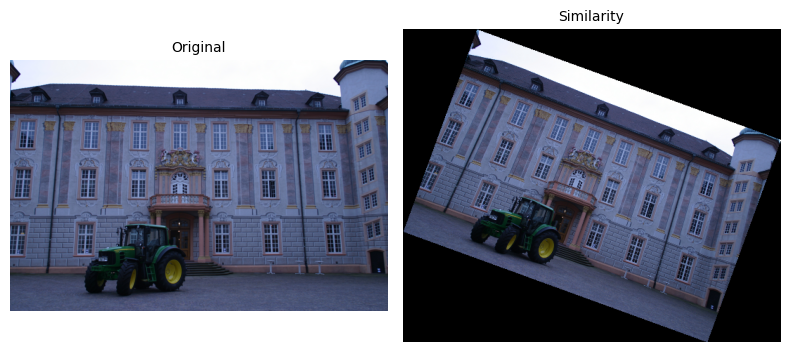

In [476]:
# 4 DOF
H = similarity(
    scale=0.5,
    theta=np.radians(20),
    trans_x=-100,
    trans_y=100
)
# Since the image is centered when plotted, the the translation coefficients are not visually apparent.

I_sim, _ = apply_H(np.array(I), H)

show_images([I, I_sim], ["Original", "Similarity"])

### **1.2 Affinities**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces an affine transformation.  </span>

In [477]:
def affinity(a, b, c, d, trans_x, trans_y):
    return np.array(
        [
            [a, b, trans_x],
            [c, d, trans_y],
            [0, 0, 1]
        ]
    )

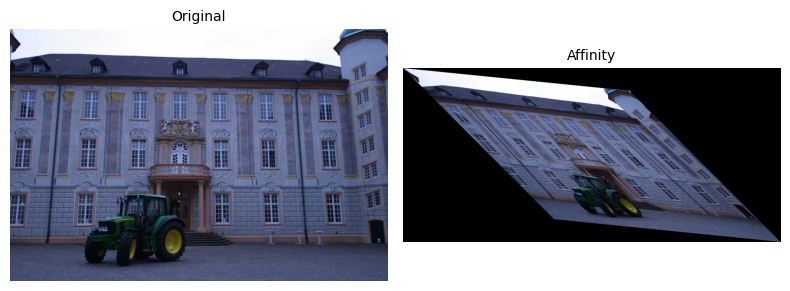

In [478]:
# 6 DOF
H = affinity(
    a=1,
    b=1,
    c=0.1,
    d=1,
    trans_x=-100,
    trans_y=100
)
# Since the image is centered when plotted, the the translation coefficients are not visually apparent.

I_aff, _ = apply_H(np.array(I), H)

show_images([I, I_aff], ["Original", "Affinity"])

<span style='color:Green'> - Decompose the affinity in four transformations: two
rotations, a scale, and a translation (you may use function *numpy.linalg.svd* for that).  </span>

The square $2 \times 2$ submatrix $A$ in $H$ can be decomposed with a singular value decomposition (SVD):
$A = USV^T$

We can rewrite this identity as $A = (UV^T) (VDSV^T) = R(\theta) R(-\phi)SR(\phi)$.

We then expand $R(\theta)$ and $R(\phi)$ with a homogeneous third component, so they become $3\times 3$ matrices.

Moreover, we define the translation matrix
$$
T = \begin{pmatrix}
1 & 0 & t_x\\
0 & 1 & t_y\\
0 & 0 & 1
\end{pmatrix}
$$.

With this, we can express H as the product of four matrices: $H = T R(\theta) R(-\phi) S R(\phi)$.

In [479]:
def decompose_affinity(H: np.array) -> Tuple[np.array, np.array, np.array, np.array]:
    # Decomposes an affinity H into four components with the SVD decomposition.
    # Two rotations, an anisotropic scaling, and a translation.
    assert H.shape == (-1, 3, 3) or H.shape == (3, 3)

    T = np.zeros(H.shape)
    T[..., :2, 2] = H[..., :2, 2]  # add translation coefficients
    T[..., :2, :2] = np.eye(2)

    U, s, Vt = LA.svd(H[..., :2, :2], full_matrices=True)
    R1, R2, S = [np.zeros(H.shape) for _ in range(3)]
    R1[..., :2, :2], R2[..., :2, :2], S[..., :2, :2] = (U @ Vt), Vt, np.diag(s)  # add scaling and rotation part
    T[..., 2, 2], R1[..., 2, 2], R2[..., 2, 2], S[..., 2, 2] = [1, 1, 1, 1]  # add homogeneous part
    return R1, R2, S, T  # H = R1 @ R2.T @ S @ R2 @ T

<span style='color:Green'> - Verify that the product of the four previous transformations
produces the same matrix H as above.  </span>

<span style='color:Green'> - verify that the proper sequence of the four previous
transformations over the image I produces the same transformed image as before.  </span>

In [480]:
np.set_printoptions(threshold=np.inf)

R1, R2, S, T = decompose_affinity(H)

## Verify that the composition of the four transformations (the product of the four matrices) gives back the original homography H.
H_comb = T @ R1 @ R2.T @ S @ R2

print(H)
print("____________")
print(f"\n> Decomposition of A into fundamental transformations through SVD:\n")
print(f'Translation:\n{T}\n')
print(f'Rotation by theta:\n{R1}\n')
print(f'Rotation by -phi:\n{R2.T}\n')
print(f'Scaling:\n{S}\n')
print(f'Rotation by phi:\n{R2}\n')
print("______\n")
print(f'H combined (multiplication of fundamental transformations matrices):\n{H_comb}')

[[   1.     1.  -100. ]
 [   0.1    1.   100. ]
 [   0.     0.     1. ]]
____________

> Decomposition of A into fundamental transformations through SVD:

Translation:
[[   1.    0. -100.]
 [   0.    1.  100.]
 [   0.    0.    1.]]

Rotation by theta:
[[ 0.91192151  0.41036468  0.        ]
 [-0.41036468  0.91192151  0.        ]
 [ 0.          0.          1.        ]]

Rotation by -phi:
[[-0.54297114 -0.83975136  0.        ]
 [-0.83975136  0.54297114  0.        ]
 [ 0.          0.          1.        ]]

Scaling:
[[1.64658561 0.         0.        ]
 [0.         0.54658561 0.        ]
 [0.         0.         1.        ]]

Rotation by phi:
[[-0.54297114 -0.83975136  0.        ]
 [-0.83975136  0.54297114  0.        ]
 [ 0.          0.          1.        ]]

______

H combined (multiplication of fundamental transformations matrices):
[[   1.     1.  -100. ]
 [   0.1    1.   100. ]
 [   0.     0.     1. ]]


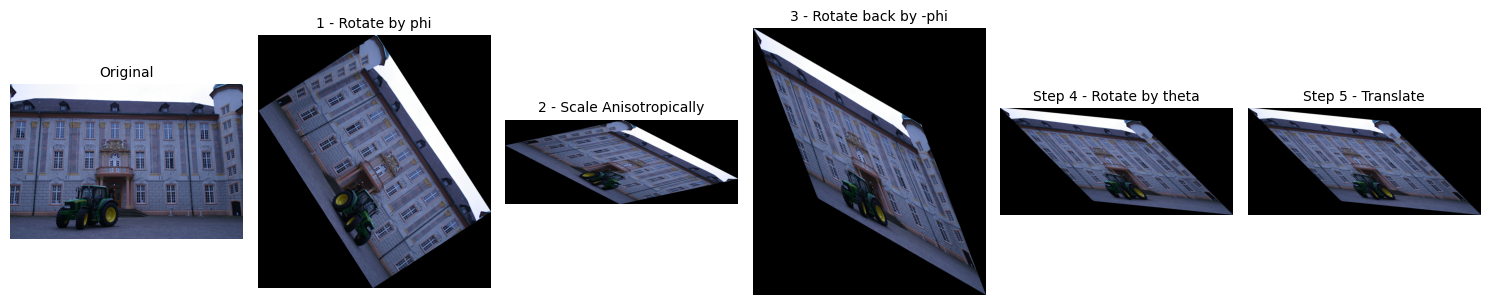

In [481]:
## Verify that the sequential application of the four previous transformations produces the same image as before.
I_decomp1, _ = apply_H(np.array(I), R2)
I_decomp2, _ = apply_H(np.array(I_decomp1), S)
I_decomp2 = crop(I_decomp2)
I_decomp3, _ = apply_H(np.array(I_decomp2), R2.T)
I_decomp3 = crop(I_decomp3)
I_decomp4, _ = apply_H(np.array(I_decomp3), R1)
I_decomp4 = crop(I_decomp4)
I_decomp5, _ = apply_H(np.array(I_decomp4), T)
I_decomp5 = crop(I_decomp5)

show_images([I, I_decomp1, I_decomp2, I_decomp3, I_decomp4, I_decomp5],
["Original", "1 - Rotate by phi", "2 - Scale Anisotropically", "3 - Rotate back by -phi", "Step 4 - Rotate by theta", "Step 5 - Translate"],
size=(15,8))

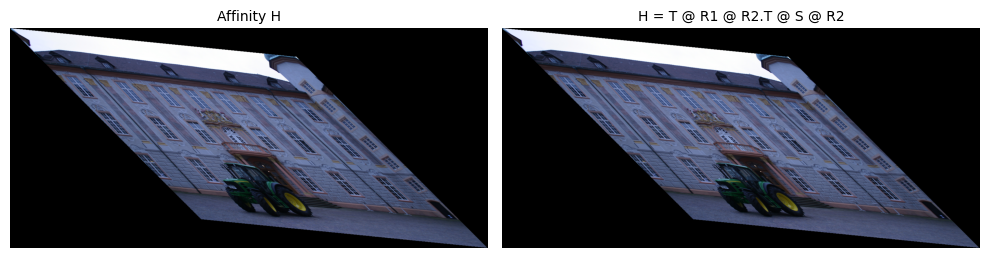

In [482]:
I1, _ = apply_H(np.array(I), np.around(H, 1))
I2, _ = apply_H(np.array(I), np.around(H_comb, 1))

show_images([I1, I2], ['Affinity H', 'H = T @ R1 @ R2.T @ S @ R2'], size=(10,5))


### **1.3 Projective transformations (Homographies)**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces a projective transformation.  </span>

In [483]:
def homography(coefs, eps = 1e-8):
    H = np.array(
        [
            [coefs[i] for i in range(3)],
            [coefs[i] for i in range(3, 6)],
            [coefs[i] for i in range(6, 8)] + [1],
        ]
    )
    # check if H is non-singular
    if abs(LA.det(H)) < eps:
        raise ValueError("A homography is bijective, but the specified coefficients result in a non-singular matrix!")
        
    return H

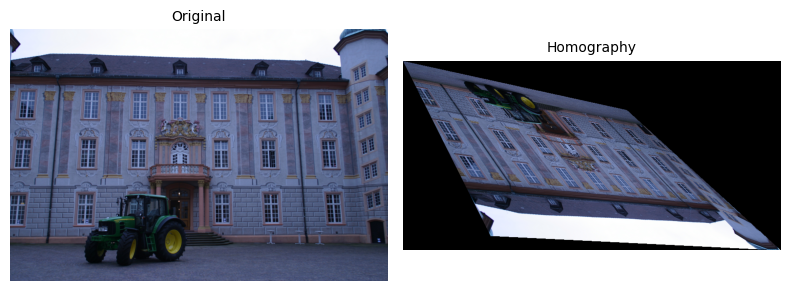

In [484]:
# 8 DOF, as homographies are defined up to scale.
coefs = [1, -.5, -0.005, 0.05, -1, .008, .0005, 0.001,]
H = homography(coefs)
I_proj, _ = apply_H(np.array(I), H)

show_images([I, I_proj], ["Original", "Homography"])

## **2. Affine Rectification**

This step is needed in order to rectify an image in a stratified way, where we first perform affine rectification (current section) and then metric rectification (Section 3).

In [485]:
# load images and lines
img_path = "../Data/0000_s.png"
I = Image.open(img_path)

# points of interest
img_id = "0000"
p1, p2 = get_line_endpoints(423, img_id)
p3, p4 = get_line_endpoints(239, img_id)
p5, p6 = get_line_endpoints(711, img_id)
p7, p8 = get_line_endpoints(564, img_id)

<span style='color:Green'> - Compute the lines l1, l2, l3, l4, that pass through the different pairs of points.  </span>

In [486]:
# For obtaining a line, an alternative to the cross product between two points is to solve a system of linear equations:
def solve_system(p1, p2):
    points = [p1, p2]
    for i, p in enumerate(points):
        if p[2] > 1e-9:
            points[i] = p / p[2]

    A = np.array([points[0][:2], points[1][:2]])
    b = np.array([-points[0][2], -points[1][2]])
    x = LA.solve(A, b)

    return np.concatenate((x, [1]))

In [487]:
# The outer (cross) product in P2 between two points is a line.
l1 = np.cross(p1, p2)
l2 = np.cross(p3, p4)
l3 = np.cross(p5, p6)
l4 = np.cross(p7, p8)

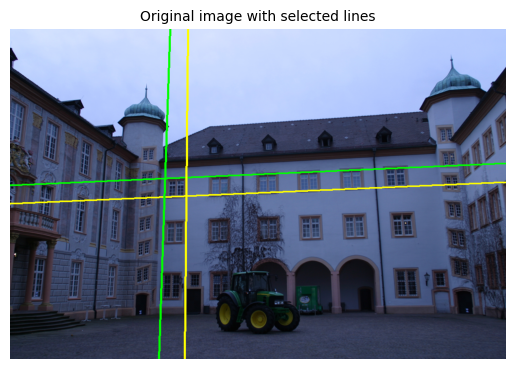

In [488]:
# show the selected lines in the image
canv = ImageDraw.Draw(I)
line_draw(l1, canv, I.size, green)
line_draw(l2, canv, I.size, yellow)
line_draw(l3, canv, I.size, green)
line_draw(l4, canv, I.size, yellow)

# The displayed lines will alter image I so we have to reopen the original image after the plot
show_images([I], ["Original image with selected lines"])
I_lines_draw = I.copy()
I = Image.open(img_path)

<span style='color:Green'> - Compute the homography that affinely rectifies the image </span>

In [489]:
def lines_intersection_map(l1, l2):
    """
    Computes the intersection point of two lines l1, l2 and maps it to (0, 0, 1).
    """
    p = np.cross(l1, l2)
    if abs(p[2]) > 1e-8:  # normalize point if it is not at infinity
        p = p / p[2]
    return p

In [490]:
# compute vanishing points vpi at which each pair of lines intersect
vanish_points_12 = lines_intersection_map(l1, l2)
vanish_points_34 = lines_intersection_map(l3, l4)

# compute the vanishing line corresponding the two vanishing points.
# Notice this is not necessarely a line at infinity, as it is the projection of the line at infinity in P3 onto P2.
vanishing_line = lines_intersection_map(vanish_points_12, vanish_points_34)
print(f"Vanishing line: {vanishing_line}")

with np.printoptions(suppress=True, precision=0):
    print(f"Vanishing line: {vanishing_line}")

Vanishing line: [9.67492178e-05 7.40193130e-04 1.00000000e+00]
Vanishing line: [0. 0. 1.]


In [491]:
def affine_correction(vanishing_line):
    """
    Builds an affine correction based on the vanishing line produced by a homography.
    """
    return np.array(
        [
            [1, 0, 0],
            [0, 1, 0],
            vanishing_line
        ]
    )

In [492]:
# build affine-rectifying homography
# Construct Homography which maps line_inf to [0, 0, 1].
Hap = affine_correction(vanishing_line)
print(Hap)

with np.printoptions(suppress=True, precision=0):
    print(Hap)

[[1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [9.67492178e-05 7.40193130e-04 1.00000000e+00]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


It is indeed the case that $H_{a \leftarrow p}^{-1}\cdot l_{vanishing} = (0, 0, 1)^T = l_{\infty}$:

In [493]:
print(np.dot(LA.inv(Hap.T), vanishing_line))

[0. 0. 1.]


<span style='color:Green'> - Compute the transformed lines lr1, lr2, lr3, lr4 and
      show the transformed lines in the transformed image. </span>

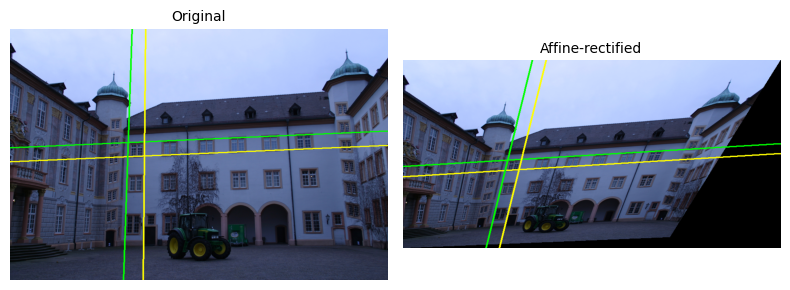

In [494]:
# affine-rectify the image
I_aff_rect, _ = apply_H(np.array(I), Hap)

# Get transformed lines 
H_metr_rect_lines = np.transpose(LA.inv(Hap))

lr1 = np.dot(H_metr_rect_lines, l1)
lr2 = np.dot(H_metr_rect_lines, l2)
lr3 = np.dot(H_metr_rect_lines, l3)
lr4 = np.dot(H_metr_rect_lines, l4)

I_aff_rect_draw = Image.fromarray(I_aff_rect.astype(np.uint8))
canv = ImageDraw.Draw(I_aff_rect_draw)

line_draw(lr1, canv, I_aff_rect_draw.size, green)
line_draw(lr2, canv, I_aff_rect_draw.size, yellow)
line_draw(lr3, canv, I_aff_rect_draw.size, green)
line_draw(lr4, canv, I_aff_rect_draw.size, yellow)

show_images([I_lines_draw, I_aff_rect_draw], ["Original", "Affine-rectified"])

<span style='color:Green'> - To evaluate the results, compute the angle between the different pair 
      of lines before and after the image transformation. </span>

In [495]:
def compute_angle_lines(l1, l2):
    """
    Computes the angle between two lines.
    """
    l1 = l1[:2] / l1[2]
    l2 = l2[:2] / l2[2]
    angle_rad = np.arccos(
        np.dot(l1, l2) / (LA.norm(l1) * LA.norm(l2))
    )
    return angle_rad * 180 / np.pi

In [496]:
print("Angle before affine correction: ")
print("l1 - l2 >", compute_angle_lines(l1, l2))
print("l3 - l4 >", compute_angle_lines(l3, l4))
print("_"*25)
print("Angle after affine correction: ")
print("l1 - l2 >", compute_angle_lines(lr1, lr2))
print("l3 - l4 >", compute_angle_lines(lr3, lr4))

Angle before affine correction: 
l1 - l2 > 0.09918160389665683
l3 - l4 > 1.3435373042187968
_________________________
Angle after affine correction: 
l1 - l2 > 0.0
l3 - l4 > 0.0


The angle after rectification is 0, meaning lines on the plane have been made parallel.

Moreover, we can also see that the corrected lines now intersect at points at infinity:

In [497]:
# As an additional check, parallel lines should meet at a point at infinity (x3 = 0)
print(np.cross(lr1, lr2))
print(np.cross(lr3, lr4))

# Indeed, rectified lines meet at ideal points, so the image has been properly affine-rectified.
with np.printoptions(suppress=True, precision=0):
    print(np.cross(lr1, lr2))
    print(np.cross(lr3, lr4))

[-36260.58652321   2192.71468497      0.        ]
[ 8.82431891e+03 -3.56609977e+04  1.13686838e-13]
[-36261.   2193.      0.]
[  8824. -35661.      0.]


## **3. Metric Rectification**

### **3.1 Metric rectification after the affine rectification (stratified solution)**

<span style='color:Green'> - Write the code that performs the metric rectification (after the affine rectification). </span>

In [498]:
# Get a second orthogonal line pair that is not parallel to the first one
p13 = lines_intersection_map(lr1, lr3)
p14 = lines_intersection_map(lr1, lr4)
p23 = lines_intersection_map(lr2, lr3)
p24 = lines_intersection_map(lr2, lr4)

# Secant lines
lr5 = np.cross(p13, p24)
lr6 = np.cross(p14, p23)

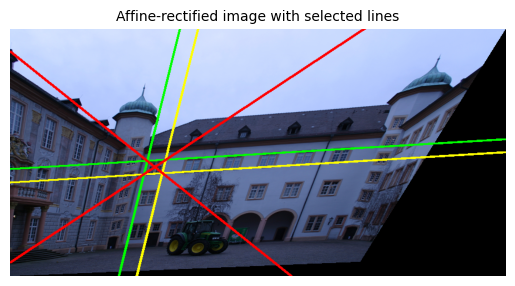

In [499]:
# show the selected lines in the image
canv = ImageDraw.Draw(I_aff_rect_draw)
line_draw(lr1, canv, I.size, green)
line_draw(lr2, canv, I.size, yellow)
line_draw(lr3, canv, I.size, green)
line_draw(lr4, canv, I.size, yellow)
line_draw(lr5, canv, I.size, red)
line_draw(lr6, canv, I.size, red)

# The displayed lines will alter image I so we have to reopen the original image after the plot
show_images([I_aff_rect_draw], ["Affine-rectified image with selected lines"])
I_aff_rect_draw_extra = I_aff_rect_draw.copy()
I = Image.open(img_path)

In [500]:
# Computing S = K @ K.T
def constraint_equation_S(l, m):
    """
    Computes the constraint equation from orthogonal lines l and m to compute matrix S = K @ K.T.
    """
    s1 = l[0] * m[0]
    s2 = l[0] * m[1] + l[1] * m[0]
    s3 = l[1] * m[1]
    return np.array([s1, s2, s3])


# Given that the image is already affinely-rectified, v.T = 0
def metric_correction(K, inv=True):
    H_A = np.identity(3)
    H_A[:2, :2] = K
    if inv:
        return LA.inv(H_A)
    return H_A

In [501]:
# Build the metric rectification matrix:
s1, s2, s3 = solve_system(constraint_equation_S(lr1, lr3), constraint_equation_S(lr5, lr6))
S = np.array([[s1, s2], [s2, s3]])

# With S = K @ K.T, we can compute K
K = LA.cholesky(S)

H_metr_rect = metric_correction(K)
print(H_metr_rect)

[[0.70822848 0.         0.        ]
 [0.18817779 1.03469686 0.        ]
 [0.         0.         1.        ]]


As qualitative evaluation method you can display the images (before and after the metric rectification) with the chosen lines printed on it.

In [502]:
def metric_line_correction(line, H, min_corners) -> np.ndarray:
    """
    Corrects a line in the metric rectified image.
    """
    H_metr_rect_lines = np.transpose(LA.inv(H))
    line_r = np.dot(H_metr_rect_lines, line)
    return np.array([line_r[0], line_r[1], line_r[2] + min_corners[0]*line_r[0] + min_corners[1]*line_r[1]])

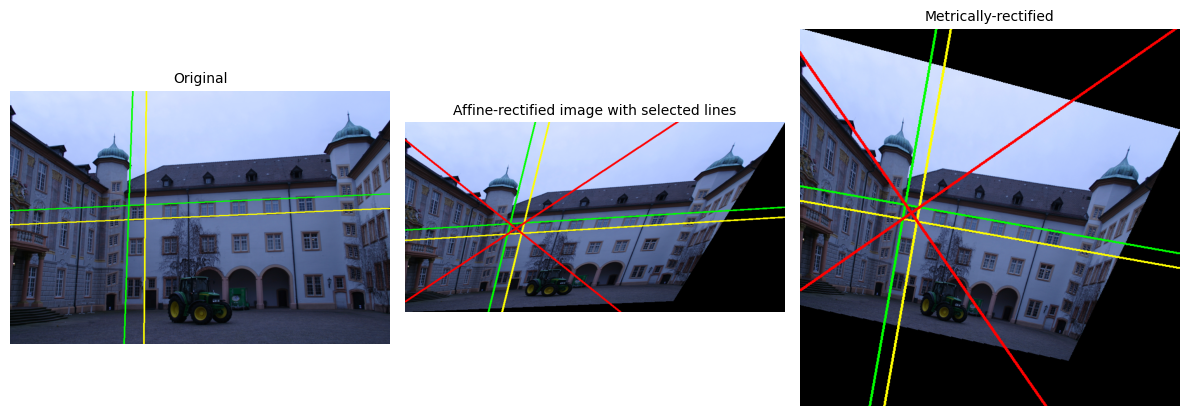

In [503]:
I_metr_rect, min_corners = apply_H(np.array(I_aff_rect), H_metr_rect)

lmr1 = metric_line_correction(lr1, H_metr_rect, min_corners)
lmr2 = metric_line_correction(lr2, H_metr_rect, min_corners)
lmr3 = metric_line_correction(lr3, H_metr_rect, min_corners)
lmr4 = metric_line_correction(lr4, H_metr_rect, min_corners)
lmr5 = metric_line_correction(lr5, H_metr_rect, min_corners)
lmr6 = metric_line_correction(lr6, H_metr_rect, min_corners)

I_metr_rect_draw = Image.fromarray(I_metr_rect.astype(np.uint8))
canv = ImageDraw.Draw(I_metr_rect_draw)

line_draw(lmr1, canv, I_metr_rect_draw.size, green)
line_draw(lmr2, canv, I_metr_rect_draw.size, yellow)
line_draw(lmr3, canv, I_metr_rect_draw.size, green)
line_draw(lmr4, canv, I_metr_rect_draw.size, yellow)
line_draw(lmr5, canv, I_metr_rect_draw.size, red)
line_draw(lmr6, canv, I_metr_rect_draw.size, red)

show_images([I_lines_draw, I_aff_rect_draw_extra, I_metr_rect_draw], ["Original", "Affine-rectified image with selected lines", "Metrically-rectified"], size=(12, 8))

<span style='color:Green'> - Compute the angles between the pair of lines before and after rectification. Comment the result. </span>


In [504]:
print("Angle before affine correction: ")
print("l1 - l2 >", compute_angle_lines(l1, l2))
print("l3 - l4 >", compute_angle_lines(l3, l4))
print("_"*25)
print("Angle after affine correction: ")
print("l1 - l2 >", compute_angle_lines(lr1, lr2))
print("l3 - l4 >", compute_angle_lines(lr3, lr4))
print("l4 - l5 >", compute_angle_lines(lr4, lr5))
print("l5 - l6 >", compute_angle_lines(lr5, lr6))
print("_"*25)
print("Angle after metric rectification: ")
print("l1 - l2 >", compute_angle_lines(lmr1, lmr2))
print("l3 - l4 >", compute_angle_lines(lmr3, lmr4))
print("l4 - l5 >", compute_angle_lines(lmr4, lmr5))
print("l5 - l6 >", compute_angle_lines(lmr5, lmr6))

Angle before affine correction: 
l1 - l2 > 0.09918160389665683
l3 - l4 > 1.3435373042187968
_________________________
Angle after affine correction: 
l1 - l2 > 0.0
l3 - l4 > 0.0
l4 - l5 > 114.68242554196509
l5 - l6 > 72.01099828301354
_________________________
Angle after metric rectification: 
l1 - l2 > nan
l3 - l4 > 0.0
l4 - l5 > 135.00000000000006
l5 - l6 > 90.0


C:\Users\MataBits\AppData\Local\Temp\ipykernel_17676\4089931716.py:7: RuntimeWarning: invalid value encountered in arccos
  angle_rad = np.arccos(


## **4. Affine and Metric Rectification of the left facade of image 0001**

<span style='color:Green'> - Write the code that rectifies the left facade of image 0001 with
      the stratified method.  </span>
      
Note: For a better visualization of the result crop the initial image so that only the left facade is visible.
      
      

<span style='color:Green'> - Show the (properly) transformed lines that are used in every step.  </span>

Affine rectification:

In [505]:
# load images and lines
img_path = "../Data/0001_s.png"
I = Image.open(img_path)

# Crop for a better visualization
I = I.crop((0, 0, I.size[0]//2, I.size[1]))

# points of interest
img_id = "0001"
p1, p2 = get_line_endpoints(613, img_id)
p3, p4 = get_line_endpoints(158, img_id)
p5, p6 = get_line_endpoints(644, img_id)
p7, p8 = get_line_endpoints(540, img_id)

In [506]:
# The outer (cross) product in P2 between two points is a line.
l1 = np.cross(p1, p2)
l2 = np.cross(p3, p4)
l3 = np.cross(p5, p6)
l4 = np.cross(p7, p8)

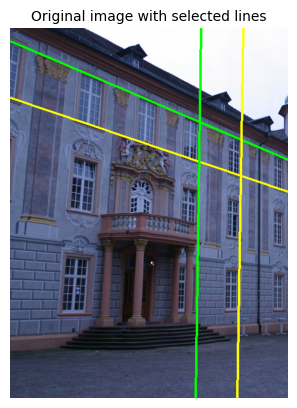

In [507]:
# show the selected lines in the image
I_lines_draw = I.copy()
canv = ImageDraw.Draw(I_lines_draw)
yellow = (255, 255, 0)
green = (0, 255, 0)
line_draw(l1, canv, I.size, green)
line_draw(l2, canv, I.size, yellow)
line_draw(l3, canv, I.size, green)
line_draw(l4, canv, I.size, yellow)

# The displayed lines will alter image I so we have to reopen the original image after the plot
show_images([I_lines_draw], ["Original image with selected lines"])

In [508]:
# compute vanishing points vpi at which each pair of lines intersect
vanish_points_12 = lines_intersection_map(l1, l2)
vanish_points_34 = lines_intersection_map(l3, l4)

# compute the vanishing line corresponding the two vanishing points.
# Notice this is not necessarely a line at infinity, as it is the projection of the line at infinity in P3 onto P2.
vanishing_line = lines_intersection_map(vanish_points_12, vanish_points_34)
print(f"Vanishing line: {vanishing_line}")

with np.printoptions(suppress=True, precision=0):
    print(f"Vanishing line: {vanishing_line}")

Vanishing line: [-9.25733366e-04 -3.57210842e-05  1.00000000e+00]
Vanishing line: [-0. -0.  1.]


In [509]:
# build affine-rectifying homography
# Construct Homography which maps line_inf to [0, 0, 1].
Hap = affine_correction(vanishing_line)
print(Hap)

with np.printoptions(suppress=True, precision=0):
    print(Hap)

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [-9.25733366e-04 -3.57210842e-05  1.00000000e+00]]
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [-0. -0.  1.]]


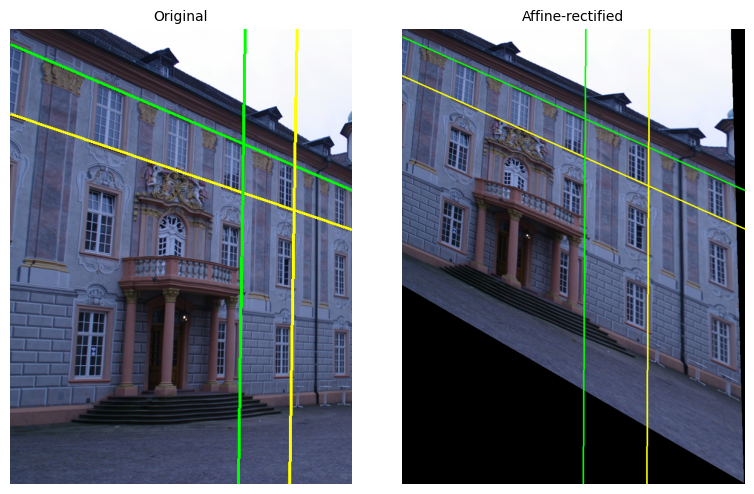

In [510]:
# affine-rectify the image
I_aff_rect, _ = apply_H(np.array(I), Hap)

# Get transformed lines 
H_metr_rect_lines = np.transpose(LA.inv(Hap))

lr1 = np.dot(H_metr_rect_lines, l1)
lr2 = np.dot(H_metr_rect_lines, l2)
lr3 = np.dot(H_metr_rect_lines, l3)
lr4 = np.dot(H_metr_rect_lines, l4)

I_aff_rect_draw = Image.fromarray(I_aff_rect.astype(np.uint8))
canv = ImageDraw.Draw(I_aff_rect_draw)

line_draw(lr1, canv, I_aff_rect_draw.size, green)
line_draw(lr2, canv, I_aff_rect_draw.size, yellow)
line_draw(lr3, canv, I_aff_rect_draw.size, green)
line_draw(lr4, canv, I_aff_rect_draw.size, yellow)

show_images([I_lines_draw, I_aff_rect_draw], ["Original", "Affine-rectified"])

In [511]:
print("Angle before affine correction: ")
print("l1 - l2 >", compute_angle_lines(l1, l2))
print("l3 - l4 >", compute_angle_lines(l3, l4))
print("_"*25)
print("Angle after affine correction: ")
print("l1 - l2 >", compute_angle_lines(lr1, lr2))
print("l3 - l4 >", compute_angle_lines(lr3, lr4))

Angle before affine correction: 
l1 - l2 > 4.420804953719115
l3 - l4 > 0.12494102020764952
_________________________
Angle after affine correction: 
l1 - l2 > 0.0
l3 - l4 > 0.0


Metric rectification after affine rectification:

In [512]:
# Get a second orthogonal line pair that is not parallel to the first one
p13 = lines_intersection_map(lr1, lr3)
p14 = lines_intersection_map(lr1, lr4)
p23 = lines_intersection_map(lr2, lr3)
p24 = lines_intersection_map(lr2, lr4)

# Secant lines
lr5 = np.cross(p13, p24)
lr6 = np.cross(p14, p23)

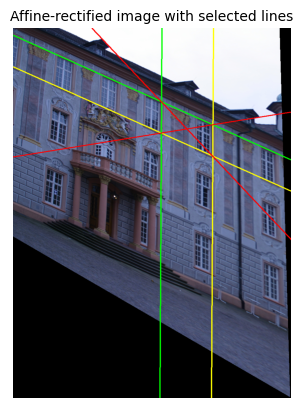

In [513]:
# show the selected lines in the image
canv = ImageDraw.Draw(I_aff_rect_draw)
line_draw(lr1, canv, I_aff_rect_draw.size, green)
line_draw(lr2, canv, I_aff_rect_draw.size, yellow)
line_draw(lr3, canv, I_aff_rect_draw.size, green)
line_draw(lr4, canv, I_aff_rect_draw.size, yellow)
line_draw(lr5, canv, I_aff_rect_draw.size, red)
line_draw(lr6, canv, I_aff_rect_draw.size, red)

# The displayed lines will alter image I so we have to reopen the original image after the plot
show_images([I_aff_rect_draw], ["Affine-rectified image with selected lines"])
I_aff_rect_draw_extra = I_aff_rect_draw.copy()

In [514]:
# Build the metric rectification matrix:
s1, s2, s3 = solve_system(constraint_equation_S(lr1, lr3), constraint_equation_S(lr5, lr6))
S = np.array([[s1, s2], [s2, s3]])
K = LA.cholesky(S)
H_metr_rect = metric_correction(K)
print(H_metr_rect)

[[ 0.75633552  0.          0.        ]
 [-0.55179169  1.23784365  0.        ]
 [ 0.          0.          1.        ]]


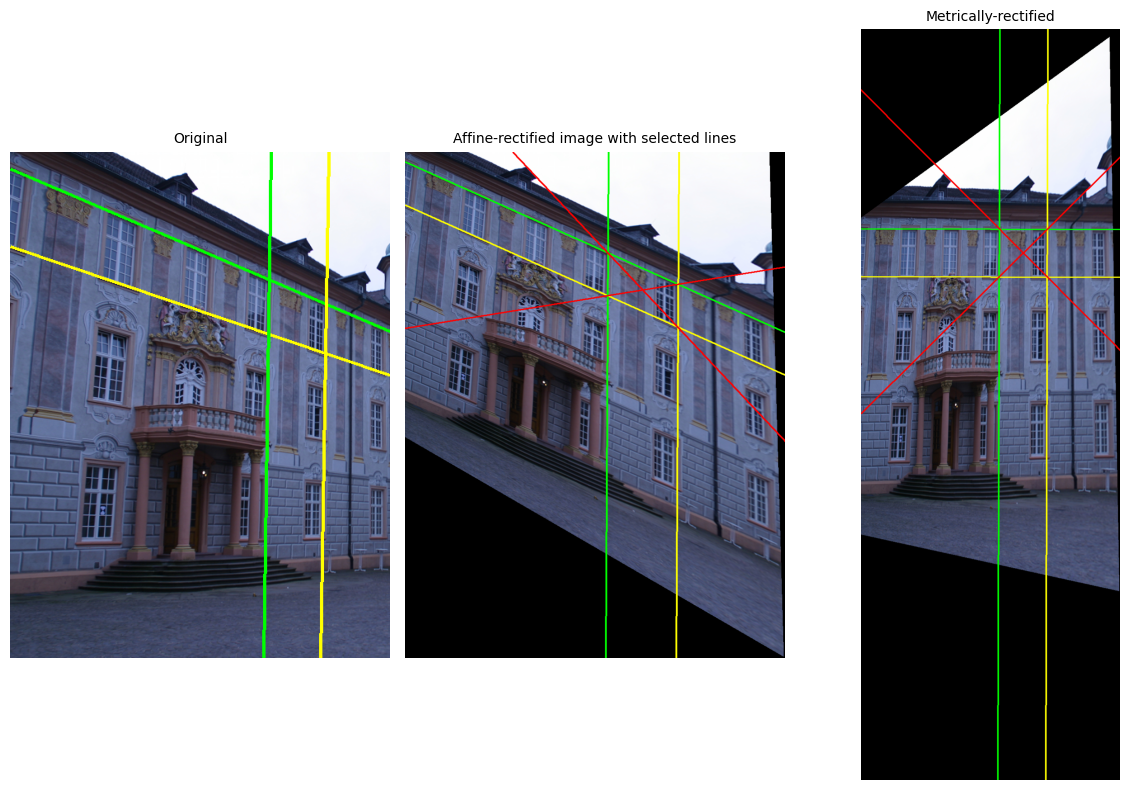

In [515]:
I_metr_rect, min_corners = apply_H(np.array(I_aff_rect), H_metr_rect)

H_metr_rect_lines = np.transpose(LA.inv(H_metr_rect))

lmr1 = metric_line_correction(lr1, H_metr_rect, min_corners)
lmr2 = metric_line_correction(lr2, H_metr_rect, min_corners)
lmr3 = metric_line_correction(lr3, H_metr_rect, min_corners)
lmr4 = metric_line_correction(lr4, H_metr_rect, min_corners)
lmr5 = metric_line_correction(lr5, H_metr_rect, min_corners)
lmr6 = metric_line_correction(lr6, H_metr_rect, min_corners)

I_metr_rect_draw = Image.fromarray(I_metr_rect.astype(np.uint8))
canv = ImageDraw.Draw(I_metr_rect_draw)

line_draw(lmr1, canv, I_metr_rect_draw.size, green)
line_draw(lmr2, canv, I_metr_rect_draw.size, yellow)
line_draw(lmr3, canv, I_metr_rect_draw.size, green)
line_draw(lmr4, canv, I_metr_rect_draw.size, yellow)
line_draw(lmr5, canv, I_metr_rect_draw.size, red)
line_draw(lmr6, canv, I_metr_rect_draw.size, red)

show_images([I_lines_draw, I_aff_rect_draw_extra, I_metr_rect_draw], ["Original", "Affine-rectified image with selected lines", "Metrically-rectified"], size=(12, 8))

In [516]:
print("Angle before affine correction: ")
print("l1 - l2 >", compute_angle_lines(l1, l2))
print("l3 - l4 >", compute_angle_lines(l3, l4))
print("_"*25)
print("Angle after affine correction: ")
print("l1 - l2 >", compute_angle_lines(lr1, lr2))
print("l3 - l4 >", compute_angle_lines(lr3, lr4))
print("l4 - l5 >", compute_angle_lines(lr4, lr5))
print("l5 - l6 >", compute_angle_lines(lr5, lr6))
print("_"*25)
print("Angle after metric rectification: ")
print("l1 - l2 >", compute_angle_lines(lmr1, lmr2))
print("l3 - l4 >", compute_angle_lines(lmr3, lmr4))
print("l4 - l5 >", compute_angle_lines(lmr4, lmr5))
print("l5 - l6 >", compute_angle_lines(lmr5, lmr6))

Angle before affine correction: 
l1 - l2 > 4.420804953719115
l3 - l4 > 0.12494102020764952
_________________________
Angle after affine correction: 
l1 - l2 > 0.0
l3 - l4 > 0.0
l4 - l5 > 43.60736960363123
l5 - l6 > 124.14390051631027
_________________________
Angle after metric rectification: 
l1 - l2 > 8.537736462515939e-07
l3 - l4 > 1.2074182697257333e-06
l4 - l5 > 135.0
l5 - l6 > 90.0


## **5. OPTIONAL: Metric Rectification in a single step**

<span style='color:Green'> - Write the code that performs metric rectification in a single step (algorithm pages 55-57, Hartley-Zisserman book). </span>

Note: Use 5 pairs of orthogonal lines. You may consider that windows are square.

In [517]:
def normalize_homogeneous(l):
    if len(l) == 3 and l[2] != 0:
        return l / l[2]
    return l

In [518]:
# load images and lines
img_path = "../Data/0000_s.png"
I = Image.open(img_path)
img_id = "0000"

In [519]:
# points of interest

# set 1 ##
# CROP = None
# p1, p2 = get_line_endpoints(423, img_id)
# p3, p4 = get_line_endpoints(711, img_id)

# p5, p6 = get_line_endpoints(239, img_id)
# p7, p8 = get_line_endpoints(564, img_id)

# p9, p10 = get_line_endpoints(226, img_id)
# p11, p12 = get_line_endpoints(533, img_id)

# p13, p14 = get_line_endpoints(366, img_id)
# p15, p16 = get_line_endpoints(575, img_id)

# p17, p18 = get_line_endpoints(118, img_id)
# p19, p20 = get_line_endpoints(356, img_id)


# l1 = np.cross(p1, p2)
# l2 = np.cross(p3, p4)
# l3 = np.cross(p5, p6)
# l4 = np.cross(p7, p8)
# l5 = np.cross(p9, p10)
# l6 = np.cross(p11, p12)
# l7 = np.cross(p13, p14)
# l8 = np.cross(p15, p16)


# pi12 = lines_intersection_map(l1, l2)
# pi34 = lines_intersection_map(l3, l4)
# pi14 = lines_intersection_map(l1, l4)
# pi23 = lines_intersection_map(l2, l3)

# # Secant lines
# l9 = np.cross(pi12, pi34)
# l10 = np.cross(pi14, pi23)


# set 2 ##
# CROP = None
# p1, p2 = get_line_endpoints(423, img_id)
# p3, p4 = get_line_endpoints(711, img_id)

# p5, p6 = get_line_endpoints(239, img_id)
# p7, p8 = get_line_endpoints(564, img_id)

# p9, p10 = get_line_endpoints(47, img_id)
# p11, p12 = get_line_endpoints(185, img_id)

# p13, p14 = get_line_endpoints(356, img_id)
# p15, p16 = get_line_endpoints(118, img_id)

# p17, p18 = get_line_endpoints(111, img_id)
# p19, p20 = get_line_endpoints(223, img_id)


# l1 = normalize_homogeneous(np.cross(p1, p2))
# l2 = normalize_homogeneous(np.cross(p3, p4))
# l3 = normalize_homogeneous(np.cross(p5, p6))
# l4 = normalize_homogeneous(np.cross(p7, p8))
# l5 = normalize_homogeneous(np.cross(p9, p10))
# l6 = normalize_homogeneous(np.cross(p11, p12))
# l7 = normalize_homogeneous(np.cross(p13, p14))
# l8 = normalize_homogeneous(np.cross(p15, p16))
# l11 = normalize_homogeneous(np.cross(p13, p14))
# l12 = normalize_homogeneous(np.cross(p15, p16))


# pi12 = lines_intersection_map(l1, l2)
# pi34 = lines_intersection_map(l3, l4)
# pi14 = lines_intersection_map(l1, l4)
# pi23 = lines_intersection_map(l2, l3)

# # Secant lines
# l9 = np.cross(pi12, pi34)
# l10 = np.cross(pi14, pi23)


# ## set 3 ##
CROP = None
p1, p2 = get_line_endpoints(423, img_id)
p3, p4 = get_line_endpoints(711, img_id)

p5, p6 = get_line_endpoints(239, img_id)
p7, p8 = get_line_endpoints(564, img_id)

p9, p10 = get_line_endpoints(575, img_id)
p11, p12 = get_line_endpoints(366, img_id)

p13, p14 = get_line_endpoints(533, img_id)
p15, p16 = get_line_endpoints(226, img_id)

p17, p18 = get_line_endpoints(492, img_id)
p19, p20 = get_line_endpoints(507, img_id)


l1 = normalize_homogeneous(np.cross(p1, p2))
l2 = normalize_homogeneous(np.cross(p3, p4))
l3 = normalize_homogeneous(np.cross(p5, p6))
l4 = normalize_homogeneous(np.cross(p7, p8))
l5 = normalize_homogeneous(np.cross(p9, p10))
l6 = normalize_homogeneous(np.cross(p11, p12))
l7 = normalize_homogeneous(np.cross(p13, p14))
l8 = normalize_homogeneous(np.cross(p15, p16))
l11 = normalize_homogeneous(np.cross(p13, p14))
l12 = normalize_homogeneous(np.cross(p15, p16))


pi12 = lines_intersection_map(l1, l2)
pi34 = lines_intersection_map(l3, l4)
pi14 = lines_intersection_map(l1, l4)
pi23 = lines_intersection_map(l2, l3)

# Secant lines
l9 = np.cross(pi12, pi34)
l10 = np.cross(pi14, pi23)
print(l10)

[  -35.69364238   -40.47216914 22907.5199763 ]


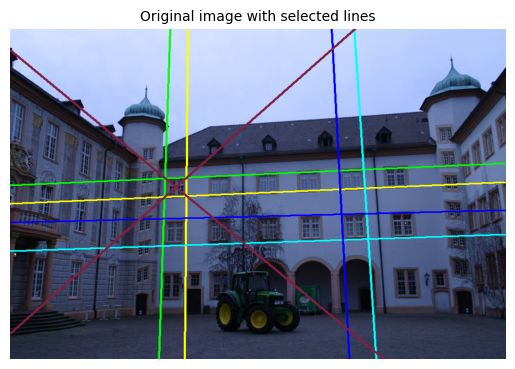

In [520]:
# show the selected lines in the image
canv = ImageDraw.Draw(I)

line_draw(l1, canv, I.size, green)
line_draw(l2, canv, I.size, green)
line_draw(l3, canv, I.size, yellow)
line_draw(l4, canv, I.size, yellow)
line_draw(l5, canv, I.size, cyan)
line_draw(l6, canv, I.size, cyan)
line_draw(l7, canv, I.size, blue)
line_draw(l8, canv, I.size, blue)
line_draw(l9, canv, I.size, carmesi)
line_draw(l10, canv, I.size, carmesi)

# The displayed lines will alter image I so we have to reopen the original image after the plot
show_images([I], ["Original image with selected lines"])
I_lines_draw = I.copy()
I = Image.open(img_path)
# # Crop for a better visualization
if CROP=="left":
    I = I.crop((0, 0, I.size[0]//2, I.size[1]))
elif CROP=="center":
    I = I.crop((2*I.size[0]//8, 0, 8*I.size[0]//8, I.size[1]))

In [521]:
def constraint_equation_C(l, m):
    """
    Computes the constraint equation from a pair of orthogonal lines (l, m)
    to later obtain matrix C of the dual conic at circular points.
    """
    C_a = l[0] * m[0]
    C_b = ( l[0] * m[1] + l[1] * m[0] ) / 2
    C_c = l[1] * m[1]
    C_d = ( l[0] * m[2] + l[2] * m[0] ) / 2
    C_e = ( l[1] * m[2] + l[2] * m[1] ) / 2
    C_f = l[2] * m[2]
    return np.array([C_a, C_b, C_c, C_d, C_e, C_f])

In [522]:
# Build the metric rectification matrix in a non-stratified fashion:
eqs = []

for l, m in [(l1, l2), (l3, l4), (l5, l6), (l7, l8), (l9, l10)]:
    eqs.append( constraint_equation_C(l, m) )

eqs = np.array(eqs)

a, b, c, d, e, f = scipy.linalg.null_space(eqs)
coeffs_C = np.array([a, b, c, d, e, f])

# get first element of each row
coeffs_C = coeffs_C[:,0]
print(coeffs_C)

[-6.92588684e-01  5.69995396e-01 -4.42067728e-01  1.05337954e-03
  1.08485631e-03  1.02144718e-06]


In [523]:
def build_conic_matrix_C(coeffs: List):
    assert len(coeffs) == 6, "Exactly 6 coefficients are needed to specify a conic's matrix in P^2."
    a, b, c, d, e, f = coeffs
    return np.array([
        [a, b/2, d/2],
        [b/2, c, e/2],
        [d/2, e/2, f],
    ]).squeeze()

In [524]:
C = build_conic_matrix_C(coeffs_C)  # build matrix for dual conic in projective space
print(C)

[[-6.92588684e-01  2.84997698e-01  5.26689769e-04]
 [ 2.84997698e-01 -4.42067728e-01  5.42428154e-04]
 [ 5.26689769e-04  5.42428154e-04  1.02144718e-06]]


In [525]:
U, s_2, Vh = np.linalg.svd(C)
H_metr_rect_nonStrat = U
print(U)

[[-8.37366749e-01 -5.46638786e-01  1.72225639e-03]
 [ 5.46641474e-01 -8.37363503e-01  2.33732851e-03]
 [ 1.64480228e-04  2.89865795e-03  9.99995785e-01]]


In [526]:
#### Alternatively ####
# U, s_2, Vh = np.linalg.svd(C[0:2, 0:2])
# A = np.dot(np.dot(U , np.diag(np.sqrt(s_2))), U.T)

# H = np.zeros((3, 3))
# H[0:2, -1] = 0
# H[0:2, 0:2] = A

# v = np.dot(np.linalg.pinv(A), C[0:2, -1])

# H[-1, 0:2] = v.T
# H[-1, -1] = 1
# H_metr_rect_nonStrat = H
########


#### Alternatively ####
# # to specify the metric correction, we need to retrieve the (affine) component S=KK^T
# # and the (projective) component v:
# S = C[:2, :2].squeeze()  # retrieve KK^T
# v = LA.solve(
#     S,
#     C[:2, 2].squeeze(),  # retrieve KK^Tv
# )  # retrieve v
#
# def metric_rectification_nonStratified(S, v, l=0.01):
#     K = LA.cholesky(S+ l*np.diag((1, 1)))
#     Hp = affine_correction(np.append(v, 1))
#     Ha = metric_correction(K, inv=False)
#     Hpa = Hp @ Ha
#     return Hsp

# # assemble the rectifying homography, by multiplying together the affine and metric corrections.
# Hsp = metric_rectification_nonStratified(S, v, l=0.5)
# H_metr_rect_nonStrat = LA.inv(Hsp)
########

# # another approach is to use the SVD to directly obtain the metric-rectifying homography
# # molt inestable:
# U, S, Vt = LA.svd(C)
# H_metr_rect_nonStrat = U @ np.diag(S)

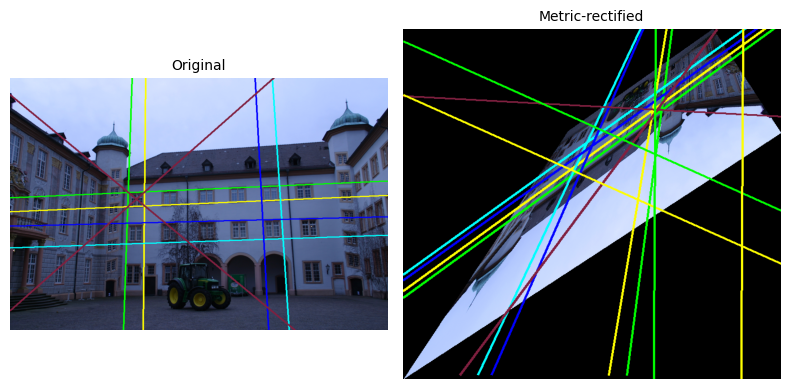

In [527]:
# metric-rectify the image in a single step
print()
I_metr_rect_nonStrat, min_corners = apply_H(np.array(I), H_metr_rect_nonStrat)

# Get transformed lines 
lr1_nonStrat = metric_line_correction(l1, H_metr_rect_nonStrat, min_corners)
lr2_nonStrat = metric_line_correction(l2, H_metr_rect_nonStrat, min_corners)
lr3_nonStrat = metric_line_correction(l3, H_metr_rect_nonStrat, min_corners)
lr4_nonStrat = metric_line_correction(l4, H_metr_rect_nonStrat, min_corners)
lr5_nonStrat = metric_line_correction(l5, H_metr_rect_nonStrat, min_corners)
lr6_nonStrat = metric_line_correction(l6, H_metr_rect_nonStrat, min_corners)
lr7_nonStrat = metric_line_correction(l7, H_metr_rect_nonStrat, min_corners)
lr8_nonStrat = metric_line_correction(l8, H_metr_rect_nonStrat, min_corners)
lr9_nonStrat = metric_line_correction(l9, H_metr_rect_nonStrat, min_corners)
lr10_nonStrat = metric_line_correction(l10, H_metr_rect_nonStrat, min_corners)

H_metr_rect_nonStrat_lines = np.transpose(LA.inv(H_metr_rect_nonStrat))

I_metr_rect_nonStrat_draw = Image.fromarray(I_metr_rect_nonStrat.astype(np.uint8))
canv = ImageDraw.Draw(I_metr_rect_nonStrat_draw)

line_draw(lr1_nonStrat, canv, I.size, green)
line_draw(lr2_nonStrat, canv, I.size, green)
line_draw(lr3_nonStrat, canv, I.size, yellow)
line_draw(lr4_nonStrat, canv, I.size, yellow)
line_draw(lr5_nonStrat, canv, I.size, cyan)
line_draw(lr6_nonStrat, canv, I.size, cyan)
line_draw(lr7_nonStrat, canv, I.size, blue)
line_draw(lr8_nonStrat, canv, I.size, blue)
line_draw(lr9_nonStrat, canv, I.size, carmesi)
line_draw(lr10_nonStrat, canv, I.size, carmesi)

line_draw(lr1, canv, I_aff_rect_draw.size, green)
line_draw(lr2, canv, I_aff_rect_draw.size, yellow)
line_draw(lr3, canv, I_aff_rect_draw.size, green)
line_draw(lr4, canv, I_aff_rect_draw.size, yellow)

show_images([I_lines_draw, I_metr_rect_nonStrat_draw], ["Original", "Metric-rectified"])

In [528]:
print("Angle before affine correction: ")
print("l1 - l2 >", compute_angle_lines(l1, l2))
print("l3 - l4 >", compute_angle_lines(l3, l4))
print("_"*25)
print("Angle after metric rectification: ")
print("l1 - l2 >", compute_angle_lines(lr1_nonStrat, lr2_nonStrat))
print("l3 - l4 >", compute_angle_lines(lr3_nonStrat, lr4_nonStrat))

Angle before affine correction: 
l1 - l2 > 85.45401946339824
l3 - l4 > 86.89673837151247
_________________________
Angle after metric rectification: 
l1 - l2 > 46.555044592284474
l3 - l4 > 44.55490332507234
